In [1]:
# @title get dataset from Kaggle
! pip install -q kaggle

# upload kaggle.json api key: https://www.kaggle.com/docs/api
from google.colab import files
files.upload()

! mkdir -p ~/.kaggle 
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download pietbroemmel/naodevils-segmentation-upper-camera

Saving kaggle.json to kaggle.json
100% 8.08G/8.08G [03:06<00:00, 31.6MB/s]



In [ ]:
# @title unzip data
!unzip -q naodevils-segmentation-upper-camera.zip -d dataset 

In [2]:
# @title setup dataset
import glob
import shutil
import os

# move all images into one folder
img_src_dir = "dataset"
img_dir = "dataset/images"
image_sub_folders = [
   "upper_00000_00500", "upper_00500_01000", "upper_01000_01500", "upper_01500_02000",
   "upper_02000_03000", "upper_03000_04000", "upper_04000_05000", "upper_05000_06000",
   "upper_06000_07000", "upper_07000_08000", "upper_08000_09000", "upper_09000_10000"
   ]
os.mkdir(img_dir)
for image_sub_folder in image_sub_folders:
  sub_folder_path = os.path.join(img_src_dir, image_sub_folder)
  for file_path in glob.glob(os.path.join(sub_folder_path, '*.*')):
    shutil.move(file_path, img_dir)
  os.rmdir(sub_folder_path)

In [3]:
# @title install tensorflow example
!pip install -q git+https://github.com/tensorflow/examples.git

In [4]:
# @title declare paths
anns_manual_all = "dataset/annotations/manual_all.json"
anns_autolabel_all = "dataset/annotations/autolabel_all.json"

anns_manual_pergame_dir = "dataset/annotations/manual_pergame"
anns_autolabel_pergame_dir = "dataset/annotations/autolabel_pergame"

anns_manual_train = "dataset/annotations/manual_train.json"
anns_manual_val = "dataset/annotations/manual_val.json"

anns_autolabel_train = "dataset/annotations/autolabel_train.json"
anns_autolabel_and_manual_train = "dataset/annotations/autolabel_and_manual_train.json"

categories=["line","ball","robot","centercircle","goal","penaltycross"]
class_id_to_color = [
  [0, 0, 0],
  [255,0,0],
  [0,255,0],
  [0,0,255],
  [122,122,0],
  [0,122,122],
  [122,0,122]
]

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


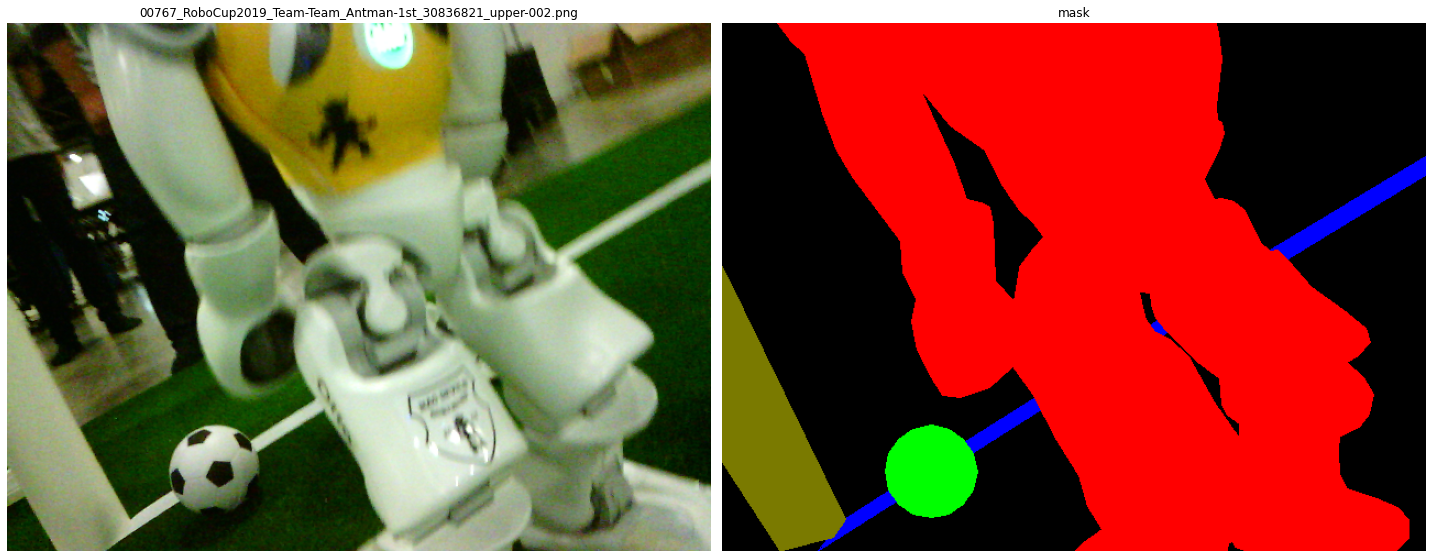

In [5]:
# @title data helper functions
from pycocotools.coco import COCO
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_segmentation_mask(annotation, width, height):
  '''returns mask with all annotations drawn on the mask'''
  mask = np.zeros((height, width), dtype=np.uint8)
  for ann in annotation:
    segmentations = ann['segmentation']
    category_id = ann['category_id']
    pts = [
          np
          .array(anno)
          .reshape(-1, 2)
          .round()
          .astype(int)
          for anno in segmentations
          ]
        
    _mask = mask.copy()
    cv2.fillPoly(_mask, pts, 10)
    mask[_mask == 10] = category_id

  return mask

def get_colored_segmentation_mask(mask, class_id_to_color):
    seg_img = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for class_id in np.unique(mask):
      seg_img[mask == class_id] = class_id_to_color[class_id]
    return seg_img

def get_figure_of_images(img_array, width, height, size_mult):
    assert(len(img_array) == width*height)

    fig = plt.figure(figsize=(width*size_mult, height*size_mult))
    for row in range(height):
        for column in range(width):
            i = row*width + column
            ax = fig.add_subplot(height, width, i+1)
            ax.set_axis_off()
            ax.title.set_text(img_array[i][0])
            ax.imshow(cv2.cvtColor(img_array[i][1], cv2.COLOR_BGR2RGB))
    
    fig.tight_layout()
    return fig

def show_img_from_coco_json(img_dir, coco_json, class_id_to_color, img_count, fig_size):
  coco = COCO(coco_json)
  img_ids = np.random.choice(list(coco.imgs.keys()), img_count)
  img_array = []
  for img_id in img_ids:
    img_data = coco.loadImgs(int(img_id))[0]
    img_path = os.path.join(img_dir, img_data["file_name"])
    assert(os.path.isfile(img_path)) # 
    img = cv2.imread(img_path)
    mask = get_segmentation_mask(coco.loadAnns(coco.getAnnIds(img_id)), 640, 480)
    cmask = get_colored_segmentation_mask(mask, class_id_to_color)
    img_array.append([img_data["file_name"], img])
    img_array.append(["mask", cmask])
  fig = get_figure_of_images(img_array, 2, img_count, fig_size)
  fig.show()

# The instances here are ignored. But they are available and can be used.
show_img_from_coco_json(img_dir, anns_manual_val, class_id_to_color, img_count=1, fig_size=10)

In [6]:
# @title create training json

import json

def save_certain_categories(json_path, save_json_path, categorie_mapping):
  coco = COCO(json_path)

  categories_new = []
  id_to_new_id = {}
  for cat_id in coco.getCatIds():
    cat_data = coco.loadCats(cat_id)[0]
    new_cat_id = categorie_mapping[cat_data["name"]]
    id_to_new_id[cat_id] = new_cat_id
    
    if new_cat_id is not None:
      cat_data["id"] = new_cat_id
      categories_new.append(cat_data)

  imgs_new = []
  anns_new = []

  for img_id in coco.imgs.keys():
    for ann_old in coco.loadAnns(coco.getAnnIds(img_id)):
      new_id = id_to_new_id[ann_old["category_id"]]
      if new_id is not None:
        ann_old["category_id"] = new_id
        anns_new.append(ann_old)


    imgs_new.append(coco.loadImgs(img_id)[0])
  
  new_annotation_data = {
      "images": imgs_new,
      "annotations": anns_new,
      "categories": categories_new
  }
  
  with open(save_json_path, 'w') as outfile:
    json.dump(new_annotation_data, outfile)

categorie_mapping_lcgp = {
  "line":1,
  "ball":None,
  "robot":None,
  "centercircle":2,
  "goal":3,
  "penaltycross":4,
}
n_classes = 5

anns_manual_train_lcgp = "train_lcgp.json"
anns_manual_val_lcgp = "val_lcgp.json"
save_certain_categories(anns_manual_train, anns_manual_train_lcgp, categorie_mapping_lcgp)
save_certain_categories(anns_manual_val, anns_manual_val_lcgp, categorie_mapping_lcgp)

loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [8]:
# @title train helper functions

import itertools

def get_img_path_annotation_list_from_json(img_dir, json_path):
  coco = COCO(json_path)
  img_path_annotation_list = []
  for img_id in coco.imgs.keys():
      img_path = os.path.join(img_dir, coco.loadImgs(img_id)[0]['file_name'])
      img_path_annotation_list.append({
        "img_path": img_path,
        "annotation": coco.loadAnns(coco.getAnnIds(img_id))
      })
  return img_path_annotation_list

def get_image_array(image_input, width, height):
    """Load image array from input imgNorm: sub_mean and imgOrdering: channels_first"""
    img = image_input
    img = cv2.resize(img, (width, height))
    img = img.astype(np.float32)
    img[:, :, 0] -= 103.939
    img[:, :, 1] -= 116.779
    img[:, :, 2] -= 123.68
    img = img[:, :, ::-1]

    return img

def get_segmentation_array(image_input, nClasses, width, height):
  """Load segmentation array from input"""
  seg_labels = np.zeros((height, width, nClasses))
  img = image_input
  img = cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
  for c in range(nClasses):
    seg_labels[:, :, c] = (img == c).astype(int)

  return seg_labels

def augment_segmentation(img, seg , augmentation):
  """augment given image and segmentation mask with an imaug augmentation"""
  # Create a deterministic augmentation from the random one
  aug_det = augmentation.to_deterministic()
  # Augment the input image
  image_aug = aug_det.augment_image(img)

  segmap = ia.SegmentationMapOnImage(seg, nb_classes=np.max(seg) + 1, shape=img.shape)
  segmap_aug = aug_det.augment_segmentation_maps(segmap)
  segmap_aug = segmap_aug.get_arr_int()

  return image_aug, segmap_aug

def image_segmentation_generator(data_list, batch_size, n_classes, input_height, input_width, output_height, output_width, augmentation=None):
  """generator for the sagmentation models"""

  zipped = itertools.cycle(data_list)

  while True:
    X = []
    Y = []
    for _ in range(batch_size):
      data = next(zipped)

      img = cv2.imread(data["img_path"])
      mask = get_segmentation_mask(data["annotation"], 640, 480)

      if augmentation != None:
        img, mask = augment_segmentation(img, mask , augmentation=augmentation)

      X.append(get_image_array(img, input_width, input_height))

      Y.append(get_segmentation_array(mask, n_classes, output_width, output_height))

    yield np.array(X), np.array(Y)

In [9]:
# @title Model

# example model from the tensorflow image segmentation tutorial:
# https://www.tensorflow.org/tutorials/images/segmentation
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

# for this model 128x128 is the only option
model_input_height = 128
model_input_width = 128
model_output_height = 128
model_output_width = 128

model = unet_model(n_classes)
model.compile(optimizer='adam',
              loss=tf.keras.losses.mse,
              metrics=['accuracy'])

9412608/9406464 [==============================] - 0s 0us/step


In [10]:
# @title Train
import imgaug as ia

batch_size = 32
steps_per_epoch = 100
epochs = 5
validation_steps = 20

aug_fliplr = ia.augmenters.Sequential([ia.augmenters.Fliplr(0.5)])

data_train = get_img_path_annotation_list_from_json(img_dir, anns_manual_train_lcgp)
train_gen = image_segmentation_generator(
    data_train, batch_size, n_classes, model_input_height, model_input_width, model_output_height, model_output_width, aug_fliplr)

data_val = get_img_path_annotation_list_from_json(img_dir, anns_manual_val_lcgp)
val_gen = image_segmentation_generator(
    data_val, batch_size, n_classes, model_input_height, model_input_width, model_output_height, model_output_width, aug_fliplr)

model.fit_generator(
    generator=train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=validation_steps,
    initial_epoch=0,
  )

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
100/100 [==============================] - 181s 2s/step - loss: 0.2689 - accuracy: 0.7942 - val_loss: 0.0900 - val_accuracy: 0.8941
Epoch 2/5
100/100 [==============================] - 180s 2s/step - loss: 0.0573 - accuracy: 0.9301 - val_loss: 0.0477 - val_accuracy: 0.9267
Epoch 3/5
100/100 [==============================] - 181s 2s/step - loss: 0.0353 - accuracy: 0.9483 - val_loss: 0.0338 - val_accuracy: 0.9372
Epoch 4/5
100/100 [==============================] - 181s 2s/step - loss: 0.0260 - accuracy: 0.9553 - val_loss: 0.0294 - val_accuracy: 0.9355
Epoch 5/5
100/100 [==============================] - 181s 2s/step - loss: 0.0215 - accuracy: 0.9577 - val_loss: 0.0250 - val_accuracy: 0.9412


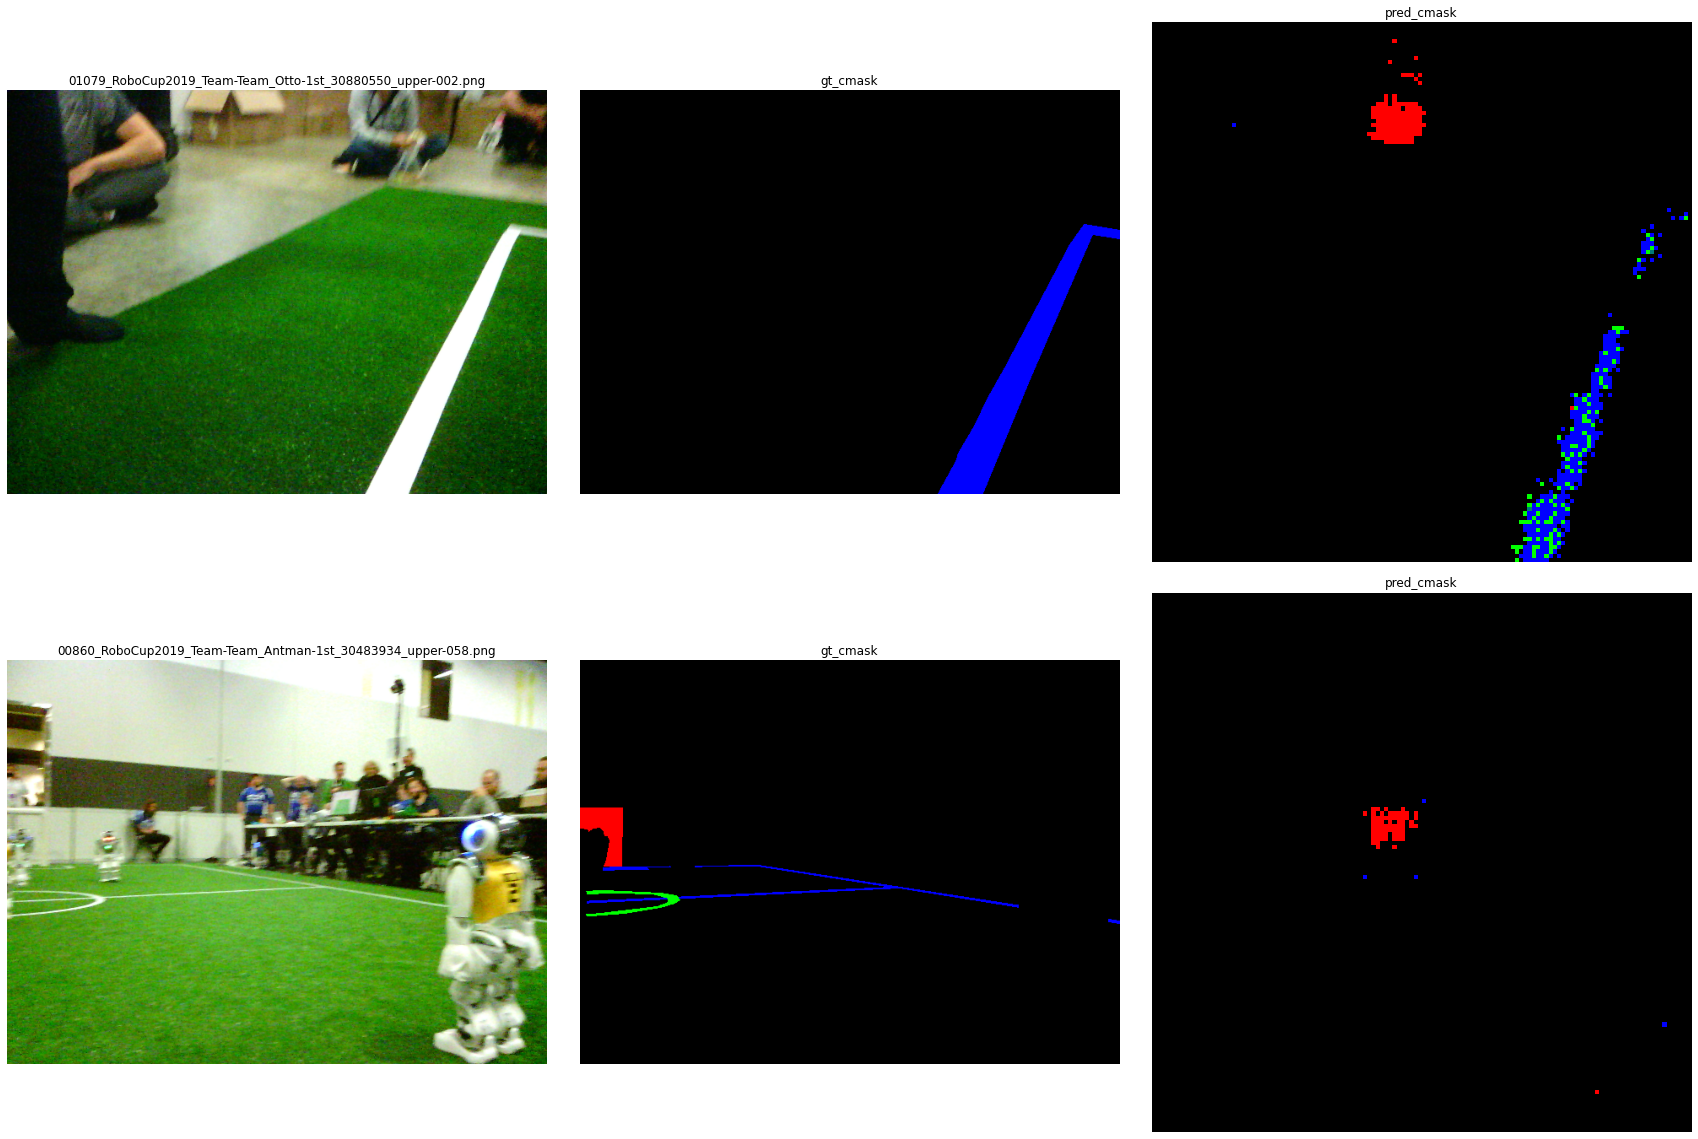

In [13]:
# @title Predict
def get_prediction(model, data_pred, model_input_height, model_input_width, class_id_to_color, num_of_images, fig_size):
  """shows predicted images with the given model from random samples """
  img_list = []
  for data in np.random.choice(data_pred, num_of_images):
    img = cv2.imread(data["img_path"])
    gt_mask = get_segmentation_mask(data["annotation"], 640, 480)
    gt_cmask = get_colored_segmentation_mask(gt_mask, class_id_to_color)

    pred = model.predict(np.array([get_image_array(img, model_input_height, model_input_width)]))
    pred_mask = np.argmax(pred[0], axis=-1)
    pred_cmask = get_colored_segmentation_mask(pred_mask, class_id_to_color)

    img_list.append([os.path.basename(data["img_path"]), img])
    img_list.append(["gt_cmask", gt_cmask])
    img_list.append(["pred_cmask", pred_cmask])
  fig = get_figure_of_images(img_list, 3, num_of_images, fig_size)
  return fig

fig = get_prediction(model, data_val, model_input_height, model_input_width, class_id_to_color, num_of_images=2, fig_size=8)